In [ ]:
#!pip install prysm
%pip install rayoptics

In [363]:
#import prysm
import rayoptics

In [364]:
# use standard rayoptics environment
from rayoptics.environment import *

# util functions
from rayoptics.util.misc_math import normalize

In [365]:
from ray_optics_criteria_ITMO import calc_loss

Create a new, empty, model

In [416]:
opm = OpticalModel() # create new model
#opm = open_model('test_new_2.629.roa') # load model from file

sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

Enter System related attributes

In [417]:
opm.system_spec.title = 'Test Model'
opm.system_spec.dimensions = 'mm'

Specify aperture, field, and wavelengths


In [418]:
# pupil - размер входного зрачка (диафрагмы)
osp['pupil'] = PupilSpec(osp, value=2.5)

# field of view - 'flds' - список точек поля (??), 'value' - maximum field, per the key (?)
# в 'flds' перечислены углы отклонения пучков от оси, по которым мы потом оцениваем качество фокуса на экране
# для лидерборда углы могут меняться
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], is_relative=False, flds=[0., 5., 10., 15., 20.])

# задаём входной диапазон длин волн, нм
osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=0)

Test .roa file params

In [7]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=20.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=5.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=10.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=15.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=20.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Created schema params

In [8]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=20.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=5.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=10.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=15.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=20.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Define interface and gap data for the sequential model

Test Schema from .roa

In [ ]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=0\nradius=0.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.3159821701196845\nradius=1.3159821701196845\nt=1.0 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.4607610829755018\nradius=1.4607610829755018\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface

In [ ]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1.0, medium=ModelGlass(nd=1.54, vd=75.0, mat='540.750', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1.0, medium=ModelGlass(nd=1.67, vd=39.0, mat='670.390', cat='user'))


In [343]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.274782      1.00000   540.750             1      1.3160
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.8364


Created Schema

В первой строчке осталось surface_od=1.0, хотя в оригинале = 0. Сразу после этого в оригинале идёт "radius=0.0", а в созданной этого нет. В первой поверхности также в оригинале есть "radius=1.3159821701196845", а в созданной - нет - так во всех поверхностях.

In [ ]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=0.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.2500000000218745\nt=1 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.212825925234053\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface_od=1.1203310303872358\nt=1 (+1);    medium: 670.390, user\n\n4: tr

непонятно, откуда берутся коэффициенты (coefs) - их мы тоже подбираем при оптимизации

In [ ]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1, medium=ModelGlass(nd=1.54, vd=75.0, mat='', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1, medium=ModelGlass(nd=1.67, vd=39.0, mat='', cat='user'))


In [397]:
opm.radius_mode = True

sm.gaps[0].thi=1e10

sm.add_surface([0., 0.], sd=0.79358)
sm.set_stop()

sm.add_surface([1.962, 1.19, 1.471, 76.6], sd=0.9380)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=1.962, ec=2.153,
                        coefs=[0., 0., -1.895e-2, 2.426e-2, -5.123e-2, 8.371e-4, 7.850e-3, 4.091e-3, -7.732e-3, -4.265e-3])

sm.add_surface([33.398, .93], sd=1.0837)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=33.398, ec=40.18,
                        coefs=[0., 0., -4.966e-3, -1.434e-2, -6.139e-3, -9.284e-5, 6.438e-3, -5.72e-3, -2.385e-2, 1.108e-2])

sm.add_surface([-2.182, .75, 1.603, 27.5], sd=1.1338)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=-2.182, ec=2.105,
                        coefs=[0., 0., -4.388e-2, -2.555e-2, 5.16e-2, -4.307e-2, -2.831e-2, 3.162e-2, 4.630e-2, -4.877e-2])

sm.add_surface([-6.367, 0.1], sd=1.5390)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=-6.367, ec=3.382,
                        coefs=[0., 0., -1.131e-1, -7.863e-2, 1.094e-1, 6.228e-3, -2.216e-2, -5.89e-3, 4.123e-3, 1.041e-3])

sm.add_surface([5.694, .89, 1.510, 56.2], sd=1.8254)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=5.694, ec=-221.1,
                        coefs=[0., 0., -7.876e-2, 7.02e-2, 1.575e-3, -9.958e-3, -7.322e-3, 6.914e-4, 2.54e-3, -7.65e-4])

sm.add_surface([9.192, .16], sd=2.3978)
sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=9.192, ec=0.9331,
                        coefs=[0., 0., 9.694e-3, -2.516e-3, -3.606e-3, -2.497e-4, -6.84e-4, -1.414e-4, 2.932e-4, -7.284e-5])

#sm.add_surface([1.674, .85, 1.510, 56.2], sd=2.4820)
#sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=1.674, ec=-7.617,
#                        coefs=[0., 0., 7.429e-2, -6.933e-2, -5.811e-3, 2.396e-3, 2.100e-3, -3.119e-4, -5.552e-5, 7.969e-6])

#sm.add_surface([1.509, .70], sd=2.9297)
#sm.ifcs[sm.cur_surface].profile = RadialPolynomial(r=1.509, ec=-2.707,
#                        coefs=[0., 0., 1.767e-3, -4.652e-2, 1.625e-2, -3.522e-3, -7.106e-4, 3.825e-4, 6.271e-5, -2.631e-5])

#sm.add_surface([0., .40, 1.516, 64.1], sd=3.3067)
sm.add_surface([0., .85 + .64 + .70 + .70 ], sd=3.4058)

opm.update_model()

sm.do_apertures = False

In [419]:
#opm.radius_mode = True
sm.do_apertures = False
sm.gaps[0].thi=1e10


# [curvature, t, 1.('medium' до заяптой), medium (после запятой без нуля на конце)], sd это surface_od,
# 1 surface - lens
curvature_1 = 0.2747823174694503
t_1 = 1.0
medium_1_1 = 1.540
medium_2_1 = 75.0
sd_1 = 0.3 # не меньше 0.2
r_1 = 3.639244363353831
coefs_1 = [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]

sm.add_surface([curvature_1, t_1, medium_1_1, medium_2_1], sd=sd_1)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_1, coefs=coefs_1)
sm.ifcs[sm.cur_surface].profile.sd = sd_1

sm.set_stop()

# 2 surface - air
curvature_2 = 0.13556582944950138
t_2 = 0.5
sd_2 = 1.4607610829755018
r_2 = 7.376490108611791
coefs_2 = [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]

sm.add_surface([curvature_2, t_2], sd=sd_2)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_2, coefs=coefs_2)
sm.ifcs[sm.cur_surface].profile.sd = sd_2


# 3 surface - lens
curvature_3 = -0.055209803982245384
t_3 = 1
medium_1_3 = 1.670
medium_2_3 = 39.0
sd_3 = 1.4312127337246845
r_3 = -18.112725057339173
coefs_3 = [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]

sm.add_surface([curvature_3, t_3, medium_1_3, medium_2_3], sd=sd_3)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_3,
                        coefs=coefs_3)
sm.ifcs[sm.cur_surface].profile.sd = sd_3

# 4 surface - air
curvature_4 = -0.2568888474926888
t_4 = 4.216392884493065
sd_4 = 1.608772352457493

sm.add_surface([curvature_4, t_4], sd=sd_4)
sm.ifcs[sm.cur_surface].profile.sd = sd_4

# img sd
sd_5 = 1.836373213770605
sm.ifcs[sm.cur_surface + 1].profile.sd = sd_5

Update the model

In [420]:
opm.update_model()

List the sequential model and the first order properties

In [415]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
 Stop:     0.274782      1.00000   540.750             1     0.30000
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.0000


In [370]:
pm.first_order_data()

efl               5.079
ffl               -3.92
pp1               1.158
bfl               4.223
ppk              0.8558
f/#               2.032
m            -5.079e-10
red          -1.969e+09
obj_dist          1e+10
obj_ang              20
enp_dist             -0
enp_radius         1.25
na obj         1.25e-10
n obj                 1
img_dist          4.223
img_ht            1.849
exp_dist          -2.35
exp_radius        1.619
na img           -0.239
n img                 1
optical invariant        0.455


In [377]:
pt.list_model()

root
├── Object
├── E1
├── E2
└── Image


Draw a lens layout to verify the model

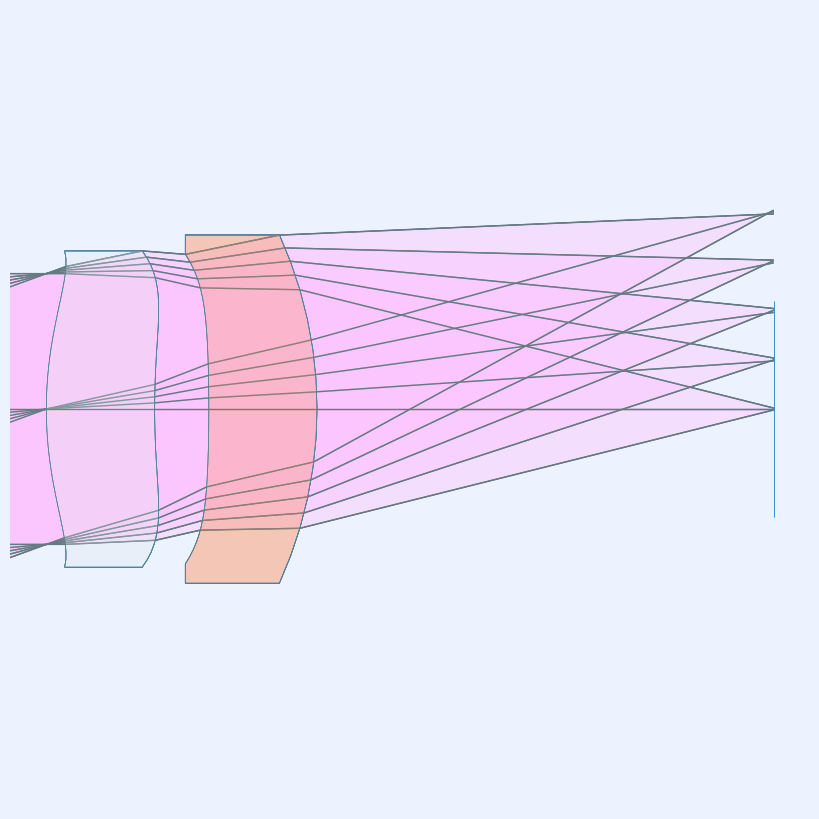

In [421]:
isdark = False

layout_plt0 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Save Current model

In [422]:
opm.save_model('test_new.roa')

Calc loss metric for optic model

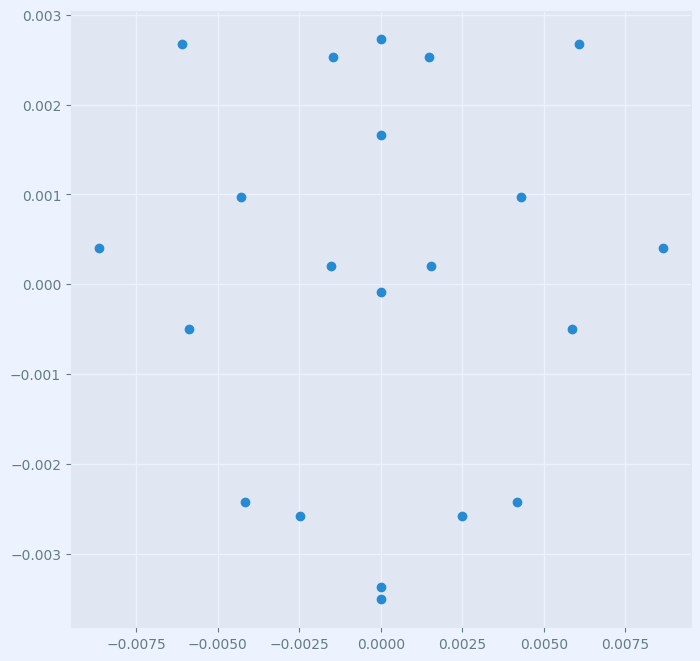

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
 Stop:     0.274782      1.00000   540.750             1     0.30000
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.0000
0 Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1 Surface(profile=EvenPolynomial(c=0.2747823174694503, cc=0.0, coefs=[0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]), interact_mode='transmit')
2 Surface(profile=EvenPolynomial(c=0.13556582944950138, cc=0.0, coefs=[0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]), interact_mode='transmit')
3 Surface(profile=EvenPolynomial(

2.6295595422351714

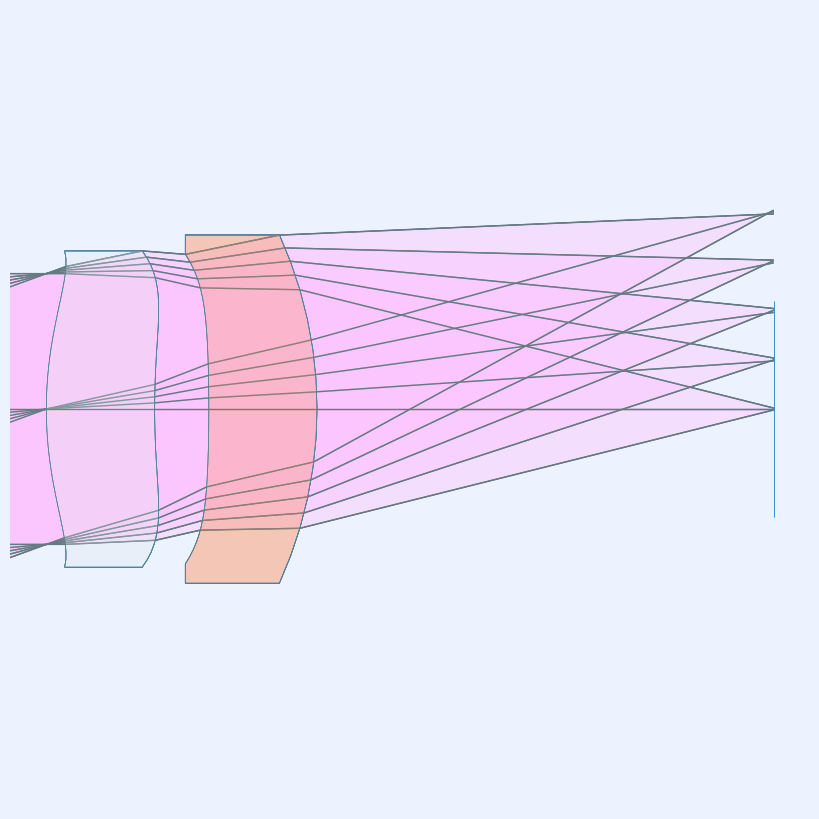

In [423]:
calc_loss('test_new.roa')

Note that in the lens layout above, the very aspheric surface shapes lead to extreme lens element shapes. The default logic used by ray-optics to apply flat bevels to concave surfaces is defeated by the aspherics that switch concavity between vertex and edge. How ray-optics renders flats can be controlled on a surface by surface basis.

First, generate a list of lens elements from the part tree.

In [ ]:
elmn = [node.id for node in pt.nodes_with_tag(tag='#element')]

Lens elements have two surfaces, each of which can be specified with or without a flat.



In [ ]:
elmn[0].sd

1.25

In [ ]:
elmn[0].do_flat1 = 'always'
elmn[0].do_flat2 = 'always'

elmn[1].do_flat1 = 'always'
elmn[1].do_flat2 = 'always'
#elmn[2].do_flat1 = 'always'
#elmn[2].do_flat2 = 'always'
#elmn[3].do_flat1 = 'always'
#elmn[3].do_flat2 = 'always'



By default, the inside diameters of a flat are set to the clear aperture of the interface in the sequential model. This can be overriden for each surface. The semi-diameter sd() of the lens element may also be set explicitly.

In [ ]:
elmn[0].sd = 1.25

elmn[1].sd = 1.75
elmn[1].flat1 = 1.25
elmn[1].flat2 = 1.645

'''
elmn[2].sd = 2.5
elmn[2].flat1 = 2.1

elmn[3].sd = 3.0
elmn[3].flat1 = 2.6

elmn[4].sd = 3.5
'''

'\nelmn[2].sd = 2.5\nelmn[2].flat1 = 2.1\n\nelmn[3].sd = 3.0\nelmn[3].flat1 = 2.6\n\nelmn[4].sd = 3.5\n'

Draw a lens layout to verify the model


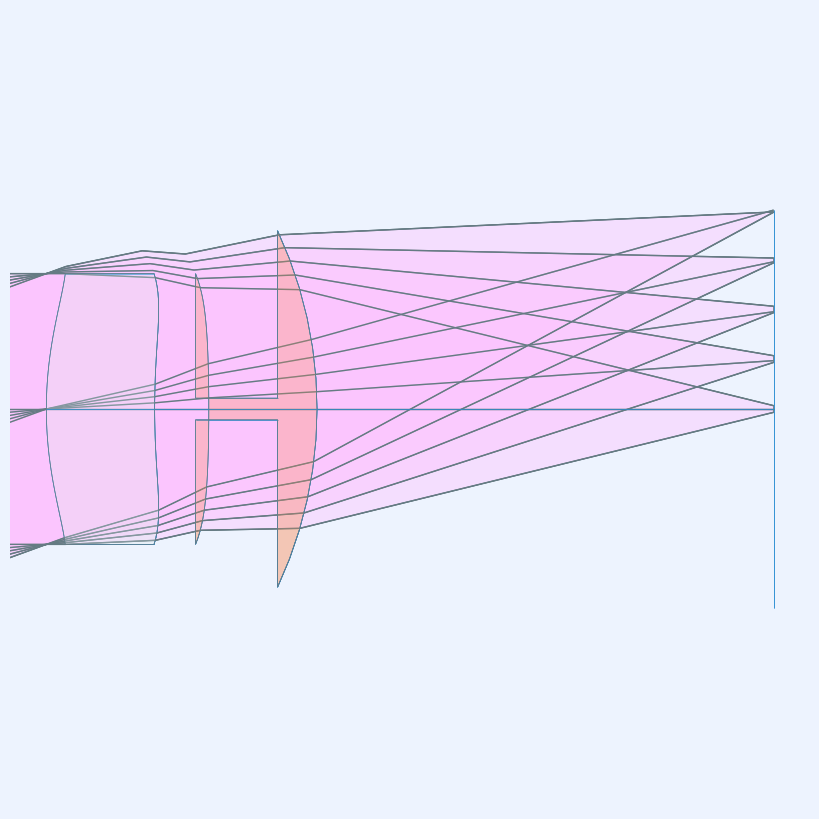

In [ ]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Plot a Spot Diagram


  warnings.warn(msg, RuntimeWarning)

  warnings.warn(msg, RuntimeWarning)



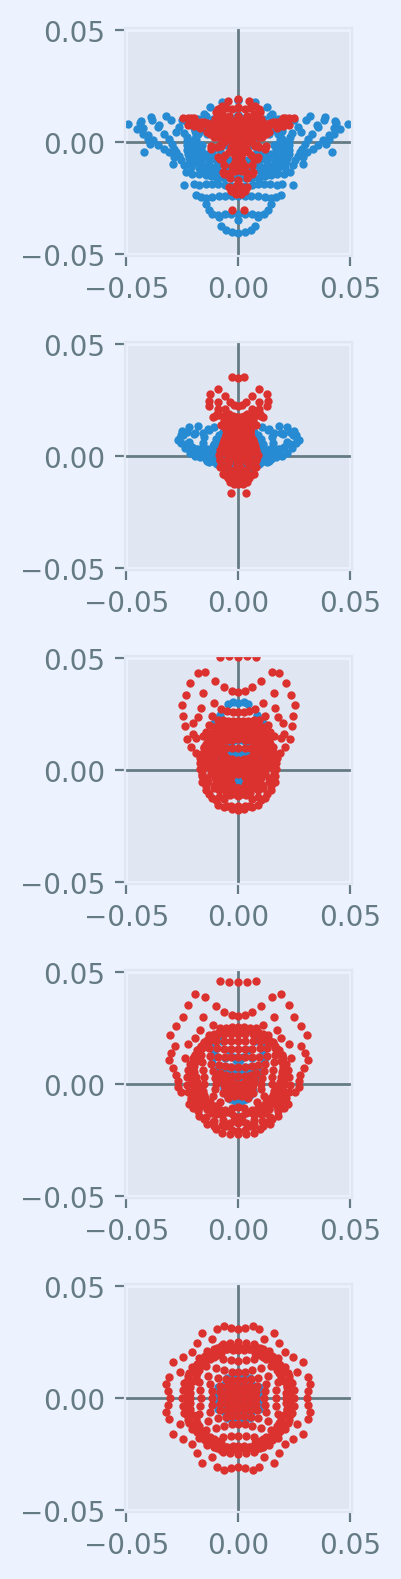

In [13]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

Third Order Seidel aberrations

In [14]:
to_pkg = compute_third_order(opm)
to_pkg

,S-I,S-II,S-III,S-IV,S-V
1,0.011521,0.012208,0.012936,0.019897,0.034792
2,0.000071,0.000575,0.004684,-0.009816,-0.041773
3,-0.002256,0.004982,-0.011003,-0.004565,0.034382
4,0.058583,-0.012936,0.002856,0.021242,-0.005321
sum,0.067919,0.004830,0.009474,0.026757,0.022080


Bar chart for surface by surface third order aberrations


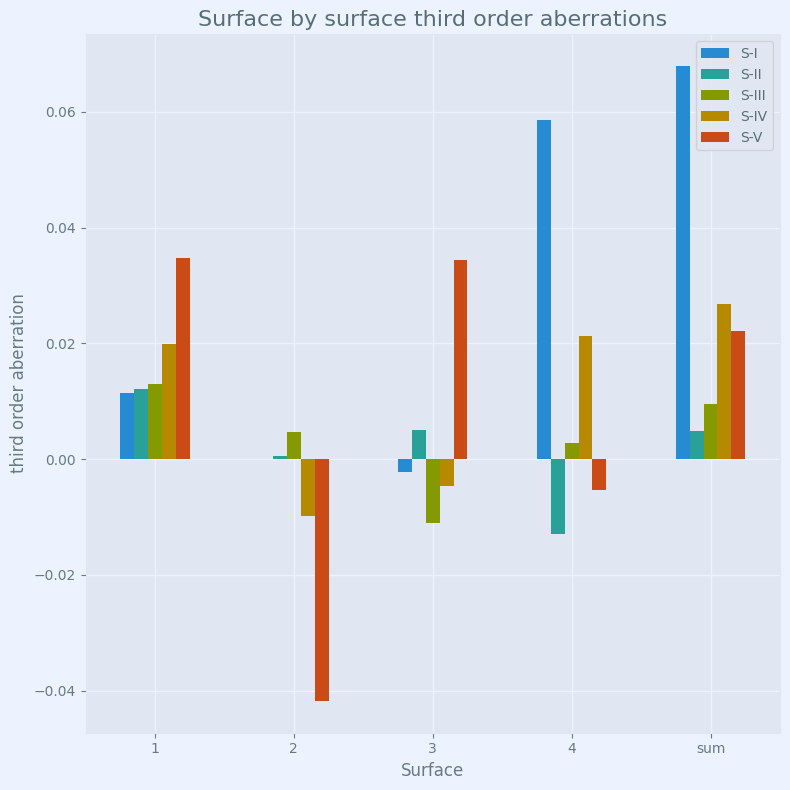

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel('Surface')
ax.set_ylabel('third order aberration')
ax.set_title('Surface by surface third order aberrations')
to_pkg.plot.bar(ax=ax, rot=0)
ax.grid(True)
fig.tight_layout()

convert aberration sums to transverse measure


In [16]:
ax_ray, pr_ray, fod = ar['parax_data']
n_last = pm.sys[-1][mc.indx]
u_last = ax_ray[-1][mc.slp]
to.seidel_to_transverse_aberration(to_pkg.loc['sum',:], n_last, u_last)

TSA   -0.141109
TCO   -0.030107
TAS   -0.114639
SAS   -0.075273
PTB   -0.055591
DST   -0.045873
dtype: float64

convert sums to wavefront measure


In [17]:
central_wv = opm.nm_to_sys_units(sm.central_wavelength())
to.seidel_to_wavefront(to_pkg.loc['sum',:], central_wv).T

W040    13.061275
W131     3.715623
W222     7.287418
W220    13.934818
W311    16.984321
dtype: float64

пока не используется

In [ ]:
# вариант собственной функции потерь
# Определение функции потерь (целевой функции)
def calc_loss(params):
    # Создаем оптическую модель
    opt_model = OpticalModel()

    # Устанавливаем параметры оптической системы из генома
    sm = opt_model.seq_model

    # Добавляем поверхности линз в оптическую модель, используя параметры из генома
    # Здесь вам нужно настроить соответствие между параметрами генома и вашей оптической схемой
    # Пример: curvature, t, 1.('medium' до заяптой), medium (после запятой без нуля на конце), sd это surface_od
    # Примечание: Этот код должен быть адаптирован к вашей оптической системе
    for i, param in enumerate(params):
        curvature, t, medium_1, medium_2, sd, *coefs = param
        sm.add_surface([curvature, t, medium_1, medium_2], sd=sd)
        sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=0.0, coefs=coefs)
        sm.ifcs[sm.cur_surface].profile.sd = sd

    # Выставляем другие параметры оптической системы (фокусное расстояние, F/# и т.д.)
    # Здесь вы должны убедиться, что ваша система соответствует ограничениям
    opt_model.radius_mode = UOM['mm']
    opt_model.wavelength = 0.55  # Длина волны
    opt_model.optical_spec.field_of_view = 2 * 0.01  # Половина диаметра входного пучка

    # Проводим трассировку лучей и вычисляем MTF
    opt_model.update_model()
    trace, wave, chief_ray, chief_ray_opd, fld, image, row, col = opt_model.trace_base()
    mtf = opt_model.evaluate_mtf()

    # Вычисляем метрику на основе MTF (например, Spot RMS) и возвращаем ее
    metric = ...  # Здесь вычислите метрику на основе MTF и других характеристик
    return metric

Оптимизация параметров генетическим алгоритмом

Change loss from file a little (model object as input and no plots)

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [426]:
# Функция для оценки оптической системы
def save_system(system, do_draw=True, path='result.roa'):
    
    opm = OpticalModel() # create new model
    sm = opm['seq_model']
    osp = opm['optical_spec']
    opm.system_spec.title = 'Test Model'
    opm.system_spec.dimensions = 'mm'

    osp['pupil'] = PupilSpec(osp, value=2.5)
    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=2.0, is_relative=False, flds=[0., 5., 10., 15., 20.])
    osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=0)

    sm.do_apertures = False
    sm.gaps[0].thi=1e10

    sm.add_surface([0., 0.])
    sm.set_stop()

    # 1 surface - lens    
    k_1 = system[0] #0.5065068740377477
    t_1 = system[1] #0.8998939657474541                    # 0.0001 < t < 1.0
    sd_1 = system[2]
    coefs_1 = [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]
    
    medium_1_1 = 1.54 * k_1 + 1.67 * (1 - k_1)
    medium_2_1 = 75.0 * k_1 + 39.0 * (1 - k_1)
    r_1 = 3.639244363353831 #2.5037557501150367
    curvature_1 = r_1 # according to doc this parameter is ovverwritten by radius 'r'

    sm.add_surface([curvature_1, t_1, medium_1_1, medium_2_1], sd=sd_1)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_1, coefs=coefs_1)

    sm.set_stop()

    # 2 surface - air
    t_2 = system[3]
    sd_2 = system[4] #0.8528730764076439
    coefs_2 = [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]

    r_2 = 7.376490108611791
    curvature_2 = r_2 

    sm.add_surface([curvature_2, t_2], sd=sd_2)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_2,coefs=coefs_2)

    # 3 surface - lens    
    k_3 = system[5]
    t_3 = system[6] # 0.0001 < t < 1.0
    sd_3 = system[7]
    coefs_3 = [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]

    medium_1_3 = 1.54 * k_3 + 1.67 * (1 - k_3)
    medium_2_3 = 75.0 * k_3 + 39.0 * (1 - k_3)    
    r_3 = -18.112725057339173
    curvature_3 = r_3 # according to doc this parameter is ovverwritten by radius 'r'

    sm.add_surface([curvature_3, t_3, medium_1_3, medium_2_3], sd=sd_3)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_3, coefs=coefs_3)

    # 4 surface - air
    t_4 = system[8] #6.8 - (t_1 + t_2 + t_3)
    sd_4 = system[9]
    curvature_4 = -0.2568888474926888
    sm.add_surface([curvature_4, t_4], sd=sd_4)

    opm.update_model()

    if do_draw:
        isdark = False
        # 1 plot
        layout_plt0 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                                do_draw_rays=True, do_paraxial_layout=False,
                                is_dark=isdark).plot()
        # 2 plot
        spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

        # 3 plot
        to_pkg = compute_third_order(opm)
        fig, ax = plt.subplots()
        ax.set_xlabel('Surface')
        ax.set_ylabel('third order aberration')
        ax.set_title('Surface by surface third order aberrations')
        to_pkg.plot.bar(ax=ax, rot=0)
        ax.grid(True)
        fig.tight_layout()

    opm.save_model(path)

In [484]:
import random
from tqdm import tqdm

isdark = False
from matplotlib.colors import LogNorm, PowerNorm, Normalize
from rayoptics.util.misc_math import normalize
import re
import io
from contextlib import redirect_stdout


# base_param
def calc_loss_mute(path2model):
    efl_for_loss=5                      #mm
    fD_for_loss=2.1
    total_length_for_loss=7.0             #mm
    radius_enclosed_energy_for_loss=50    #micron
    perc_max_enclosed_energy_for_loss=80    #%
    perc_min_enclosed_energy_for_loss=50    #%
    min_thickness_for_loss=0.1              #mm
    min_thickness_air_for_loss=0.0            #mm
    number_of_field=5
    number_of_wavelength=2

    def funct_loss_enclosed_energy(enclosed_energy,perc_max_enclosed_energy_for_loss,perc_min_enclosed_energy_for_loss):
        if enclosed_energy<perc_max_enclosed_energy_for_loss:
            if enclosed_energy<perc_min_enclosed_energy_for_loss:
                loss_enclosed_energy=1e3
            else:
                loss_enclosed_energy=(perc_max_enclosed_energy_for_loss-enclosed_energy)
        else:
            loss_enclosed_energy=0
        return loss_enclosed_energy

    def get_thichness(sm):
        f = io.StringIO()
        with redirect_stdout(f):
            sm.list_model()
        s = f.getvalue()
        rows = re.split(r"\n", s)
        thickness_list = []
        thickness_material_list=[]
        thickness_air_list=[]
        for row in rows[1:-1]:
            row = re.sub(r'\s+',r'!', row)
            values = re.split(r"!", row)
            if values[4]!='air' and values[4]!='1':
                thickness_material_list.append(float(values[3]))
            if values[4]=='air' and values[4]!='1':
                thickness_air_list.append(float(values[3]))
            thickness_list.append(float(values[3]))      #3 - thickness, 2 - curvature, 4 - type of material
        number_of_surfaces=len(rows)-2
        return thickness_list, thickness_material_list, thickness_air_list, number_of_surfaces

    opm = path2model#open_model(f'{path2model}', info=True)

    sm = opm['seq_model']
    osp = opm['optical_spec']
    pm = opm['parax_model']
    em = opm['ele_model']
    pt = opm['part_tree']
    ar = opm['analysis_results']

    pm.__dict__

    efl=pm.opt_model['analysis_results']['parax_data'].fod.efl
    fD=pm.opt_model['analysis_results']['parax_data'].fod.fno


    ax_ray, pr_ray, fod = ar['parax_data']
    u_last = ax_ray[-1][mc.slp]
    central_wv = opm.nm_to_sys_units(sm.central_wavelength())
    n_last = pm.sys[-1][mc.indx]
    to_df = compute_third_order(opm)

    tr_df=to_df.apply(to.seidel_to_transverse_aberration, axis='columns', args=(n_last,u_last))
    distortion=tr_df.to_numpy()[-1,5]

    field=0
    psf = SpotDiagramFigure(opm)
    test_psf = psf.axis_data_array[field][0][0][0]
    test_psf[:,1]=test_psf[:,1]-np.mean(test_psf[:,1])


    fld, wvl, foc = osp.lookup_fld_wvl_focus(0)
    #sm.list_model()
    #sm.list_surfaces()
    efl=pm.opt_model['analysis_results']['parax_data'].fod.efl

    #pm.first_order_data()
    opm.update_model()

    # total_length=0
    # min_thickness=0.15
    if abs(efl-efl_for_loss)>0.25:
        loss_focus=1e2*(efl-efl_for_loss)**2
    else:
        loss_focus=0

    if abs(fD)>=fD_for_loss:
        loss_FD=5*1e4*(fD-fD_for_loss)**2
    else:
        loss_FD=0


    thickness_list,thickness_material_list,thickness_air_list, number_of_surfaces=get_thichness(sm)
    #print(thickness_list)
    total_length=np.sum(thickness_list[1:])

    min_thickness=np.min(thickness_material_list)
    min_thickness_air=np.min(thickness_air_list)
    if (total_length-total_length_for_loss)>0:
        loss_total_length=1e4*(total_length-total_length_for_loss)**2
    else:
        loss_total_length=0

    if min_thickness<min_thickness_for_loss:
        loss_min_thickness=1e6*(min_thickness-min_thickness_for_loss)**2
    else:
        loss_min_thickness=0

    if min_thickness_air<min_thickness_air_for_loss:
        loss_min_thickness_air=8e4*(min_thickness_air-min_thickness_air_for_loss)**2
    else:
        loss_min_thickness_air=0


    loss_enclosed_energy_all=0
    loss_rms_all=0
    temp=0
    for idx_field in range(number_of_field):
        for idx_wavelength in range(number_of_wavelength):
            test_psf = psf.axis_data_array[idx_field][0][0][idx_wavelength]
            test_psf[:,1]=test_psf[:,1]-np.mean(test_psf[:,1])
            r_psf=np.sort(np.sqrt(test_psf[:,0]**2+test_psf[:,1]**2))
            enclosed_energy=100*np.sum(r_psf<=radius_enclosed_energy_for_loss/1e3)/len(test_psf[:,0])
            loss_enclosed_energy=funct_loss_enclosed_energy(enclosed_energy,perc_max_enclosed_energy_for_loss,perc_min_enclosed_energy_for_loss)
            loss_enclosed_energy_all=loss_enclosed_energy_all+loss_enclosed_energy

            dl=int(np.floor(len(test_psf[:,0])*perc_max_enclosed_energy_for_loss/100))
            loss_rms=np.sqrt(np.sum((1e3*r_psf[:dl])**2)/dl)
            loss_rms_all=loss_rms_all+loss_rms

            temp=temp+1
    loss_enclosed_energy_all=loss_enclosed_energy_all/temp
    loss_rms_all=loss_rms_all/temp
    loss=loss_focus+loss_FD+loss_total_length+loss_min_thickness+loss_min_thickness_air+loss_enclosed_energy_all+loss_rms_all
    return(loss)


# Функция для генерации случайной оптической системы
def generate_random_system(fine_tune_system):
    system = []

    if fine_tune_system:
        #Генерация параметров для линзы
        k = random.uniform(0.7, 1.0)           # k - соотношение смешивания материалов: k = 0.2 => 0.2 материала #1 и 0.8 материала #2
        t = random.uniform(0.7, 1.0)
        sd_1 = random.uniform(1.1, 1.4)        # sd - semi-diameter профиля
        r_1 = random.uniform(-7.0, -3.0)       

        # Генерация параметров для слоя воздуха
        sd_2 = random.uniform(1.0, 1.3)        # - 4-ый параметр в списке system!
        r_2 = random.uniform(-8.0, -3.0)
        t_prev_air = random.uniform(0.2, 0.7)

    else:
        k_1 = random.uniform(0.0, 1.0)  
        t_1 = random.uniform(0.001, 1.0)
        sd_1 = random.uniform(1.25, 1.9)
        
        t_2 = random.uniform(0.001, 1.0)
        sd_2 = random.uniform(1.25, 1.9) 

        k_3 = random.uniform(0.0, 1.0)  
        t_3 = random.uniform(0.001, 1.0)
        sd_3 = random.uniform(1.25, 1.9)
        
        t_4 = random.uniform(3.7, 4.5)
        sd_4 = random.uniform(1.25, 1.9) 
        '''
        if random.uniform(0.0, 1.0) >= 0.5 or is_first_lens:
            r_1 = random.uniform(1.0, 10.0)       # r - радиус кривизны (замещает величину кривизны "curvature")
            r_2 = random.uniform(1.0, 10.0)
        else:
            r_1 = random.uniform(-10.0, -1.0)
            r_2 = random.uniform(-10.0, -1.0)
        '''
    
    system.extend([k_1, t_1, sd_1, t_2, sd_2, k_3, t_3, sd_3, t_4, sd_4]) # если линза не первая, генерируем ширину слоя воздуха после предыдущей линзы до текущей

    return system

# Функция для оценки оптической системы
def evaluate_system(system):

    opm = OpticalModel() # create new model
    sm = opm['seq_model']
    osp = opm['optical_spec']
    opm.system_spec.title = 'Test Model'
    opm.system_spec.dimensions = 'mm'

    osp['pupil'] = PupilSpec(osp, value=2.5)
    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=2.0, is_relative=False, flds=[0., 5., 10., 15., 20.])
    osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=0)

    sm.do_apertures = False
    sm.gaps[0].thi=1e10

    sm.add_surface([0., 0.])
    sm.set_stop()

    # 1 surface - lens    
    k_1 = system[0] #0.5065068740377477
    t_1 = system[1] #0.8998939657474541                    # 0.0001 < t < 1.0
    sd_1 = system[2]
    coefs_1 = [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]
    
    medium_1_1 = 1.54 * k_1 + 1.67 * (1 - k_1)
    medium_2_1 = 75.0 * k_1 + 39.0 * (1 - k_1)
    r_1 = 3.639244363353831 #2.5037557501150367
    curvature_1 = r_1 # according to doc this parameter is ovverwritten by radius 'r'

    sm.add_surface([curvature_1, t_1, medium_1_1, medium_2_1], sd=sd_1)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_1, coefs=coefs_1)

    sm.set_stop()

    # 2 surface - air
    t_2 = system[3]
    sd_2 = system[4] #0.8528730764076439
    coefs_2 = [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]

    r_2 = 7.376490108611791
    curvature_2 = r_2 

    sm.add_surface([curvature_2, t_2], sd=sd_2)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_2,coefs=coefs_2)

    # 3 surface - lens    
    k_3 = system[5]
    t_3 = system[6] # 0.0001 < t < 1.0
    sd_3 = system[7]
    coefs_3 = [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]

    medium_1_3 = 1.54 * k_3 + 1.67 * (1 - k_3)
    medium_2_3 = 75.0 * k_3 + 39.0 * (1 - k_3)    
    r_3 = -18.112725057339173
    curvature_3 = r_3 # according to doc this parameter is ovverwritten by radius 'r'

    sm.add_surface([curvature_3, t_3, medium_1_3, medium_2_3], sd=sd_3)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_3, coefs=coefs_3)

    # 4 surface - air
    t_4 = system[8] #6.8 - (t_1 + t_2 + t_3)
    sd_4 = system[9]
    #r_4 = system[5]
    curvature_4 = -0.2568888474926888
    #coefs_4 = [0., 0., -1.131e-1, -7.863e-2, 1.094e-1, 6.228e-3, -2.216e-2, -5.89e-3, 4.123e-3, 1.041e-3]

    sm.add_surface([curvature_4, t_4], sd=sd_4)
    #sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_4,coefs=coefs_4)

    #print(system)

    opm.update_model()

    return calc_loss_mute(opm)

# Оператор селекции для выбора лучших систем
def select_best(population, scores, num_parents):
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i])
    parents = [population[i] for i in sorted_indices[:num_parents]]
    return parents

# Оператор скрещивания (кроссовера)
def crossover(parent1, parent2, alpha=0.5):
    # Здесь можно реализовать различные способы скрещивания параметров
    # линз от двух родителей, например, одноточечное скрещивание.
    #crossover_point = random.randint(1, len(parent1) - 1)
    #child = parent1[:crossover_point] + parent2[crossover_point:]

    #реализация варианта кроссовера - смешивание параметров
    child = []
    for i in range(len(parent1)):
        if random.random() < alpha:
            child.append(parent1[i])
        else:
            child.append(parent2[i])
    return child

# Оператор мутации
def mutate(system, mutation_rate, fine_tune_system):
    # Здесь можно реализовать мутацию параметров системы с заданной вероятностью
    for i in range(len(system)):
        if random.random() < mutation_rate:
            if fine_tune_system:
                # Произведите мутацию для i-й линзы, например, изменение радиуса кривизны или коэффициентов
                if i in [2, 4]:                                     # мутация sd
                    system[i] += random.uniform(-0.005, 0.005)
                


                elif i in [1, 6]:                                   # мутация t
                    if system[i] < 0.01: 
                        system[i] += random.uniform(0.0, 0.01)
                    elif system[i] > 0.9:
                        system[i] += random.uniform(-0.01, 0.0)
                    else:
                        system[i] += random.uniform(-0.01, 0.01)
                else:                                               # мутация k
                    if system[i] < 0.05: 
                        system[i] += random.uniform(0.0, 0.01)
                    elif system[i] > 0.95:
                        system[i] += random.uniform(-0.01, 0.0)
                    else:
                        system[i] += random.uniform(-0.01, 0.01)
            else:
                if i in [2, 4, 7, 9]:                               # мутация sd
                    if system[i] <= 1.26: 
                        system[i] += random.uniform(0.0, 0.01)
                    else:
                        system[i] += random.uniform(-0.01, 0.01)
                elif i in [1, 3, 6, 8]:                             # мутация t
                    if system[i] <= 0.01: 
                        system[i] += random.uniform(0.0, 0.05)
                    elif system[i] > 0.9:
                        system[i] += random.uniform(-0.05, 0.0)
                    else:
                        system[i] += random.uniform(-0.05, 0.05)
                else:                                               # мутация k
                    if system[i] < 0.05: 
                        system[i] += random.uniform(0.0, 0.05)
                    elif system[i] > 0.95:
                        system[i] += random.uniform(-0.05, 0.0)
                    else:
                        system[i] += random.uniform(-0.05, 0.05)

    return system

# Определение параметров ГА
population_size = 70 # 40
num_generations = 50 #
mutation_rate = 0.8
num_parents = 10 # 20

# если грубо ищем параметры, то False, если нужна тонкая настройка - True
fine_tune_system = False 
is_first_lens = False

# Главный цикл оптимизации
rough_system = [0.9399792848207437,0.9041680021189378,1.2735134343462693,-5.525339690893682,1.1307157810279673,-5.01715901324439,0.4988574792898446]

population = [generate_random_system(fine_tune_system) for _ in range(population_size)]

if fine_tune_system:
    population += [rough_system]

for generation in tqdm(range(num_generations)):
    scores = [evaluate_system(system) for system in population]
    parents = select_best(population, scores, num_parents)

    new_population = []
    while len(new_population) < population_size:
        parent1, parent2 = random.choice(parents), random.choice(parents)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate, fine_tune_system)
        new_population.append(child)
    
    population = new_population

# Найденная оптимальная система будет в population[0]
optimal_system = population[0]

100%|██████████| 50/50 [1:48:05<00:00, 129.70s/it]


In [485]:
# После вычисления оценок для всех схем в текущем поколении
scores = [evaluate_system(system) for system in population]

# Сортируем индексы схем в порядке убывания оценок
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=False)

# Создаем новый список population, упорядоченный по убыванию оценок
population_2 = [population[i] for i in sorted_indices]

грубый поиск для 1 линзы метрика = 1413.2084695151943
[0.5165797176824761,
 0.904091111454054,
 1.604376995586916,
 2.4956896193381595,
 1.153725860151368,
 10.504895416952536]
 
finetune с явным добавлением rough получилось 1248.240536201947 - его и взял за основу первой линзы и воздуха 
[0.5065068740377477,
 0.8998939657474541,
 1.4962263424255748,
 2.5037557501150367,
 0.8528730764076439,
 10.506354958280982]

 грубый поиск для 2 линзы метрика = 1260.6540101577052
[0.9399792848207437,
 0.9041680021189378,
 1.2735134343462693,
 -5.525339690893682,
 1.1307157810279673,
 -5.01715901324439,
 0.4988574792898446]

 finetune с явным добавлением rough получилось 1257.1557100265518
 [0.9571739389132269,
 0.9007277628982131,
 1.0542074119423646,
 -3.567203207708749,
 1.126400828390871,
 -3.358896560105352,
 0.597790824413846]
 

In [486]:
evaluate_system(population_2[0])

8.404815022368174

0.6 mut 30 generations

In [450]:
evaluate_system(population_2[0])

10.426286365619704

12.460575546490265

In [475]:
population_2[0]

[0.7864487180662644,
 0.9292203628917483,
 1.0147649721044771,
 0.6267575500925239,
 1.0717907130812638,
 0.06112435284829167,
 0.897895236582004,
 1.3583125992675402,
 4.1091998911767345,
 1.6877497494884919]

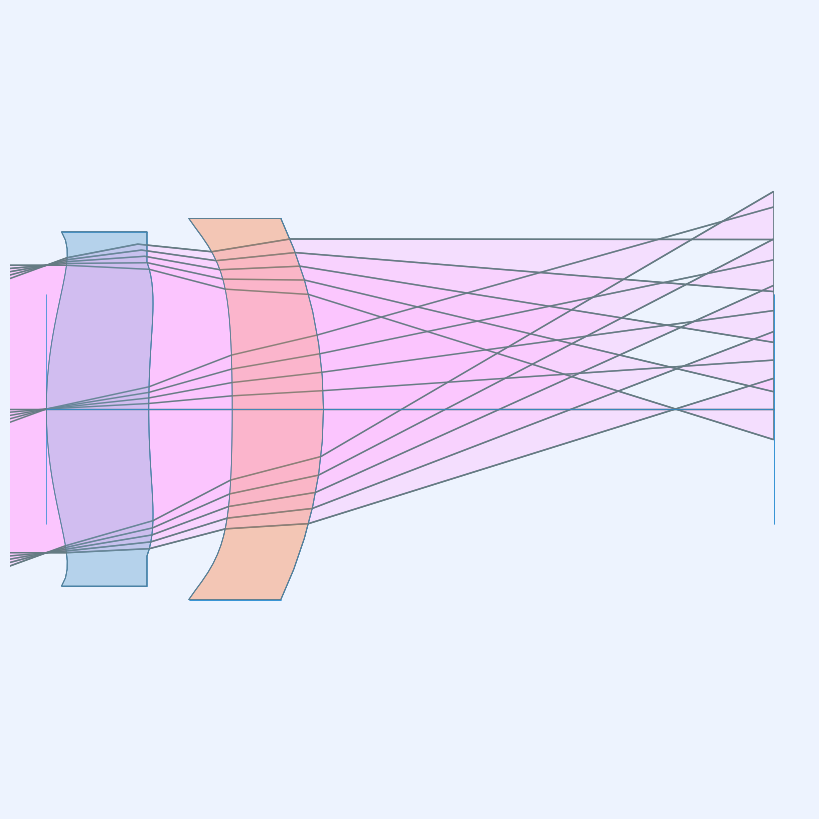

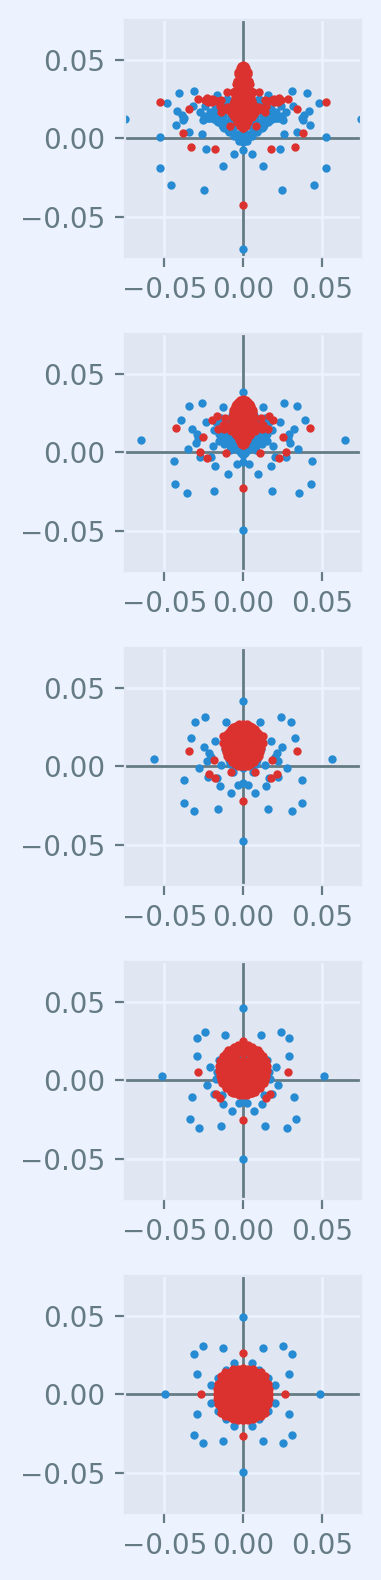

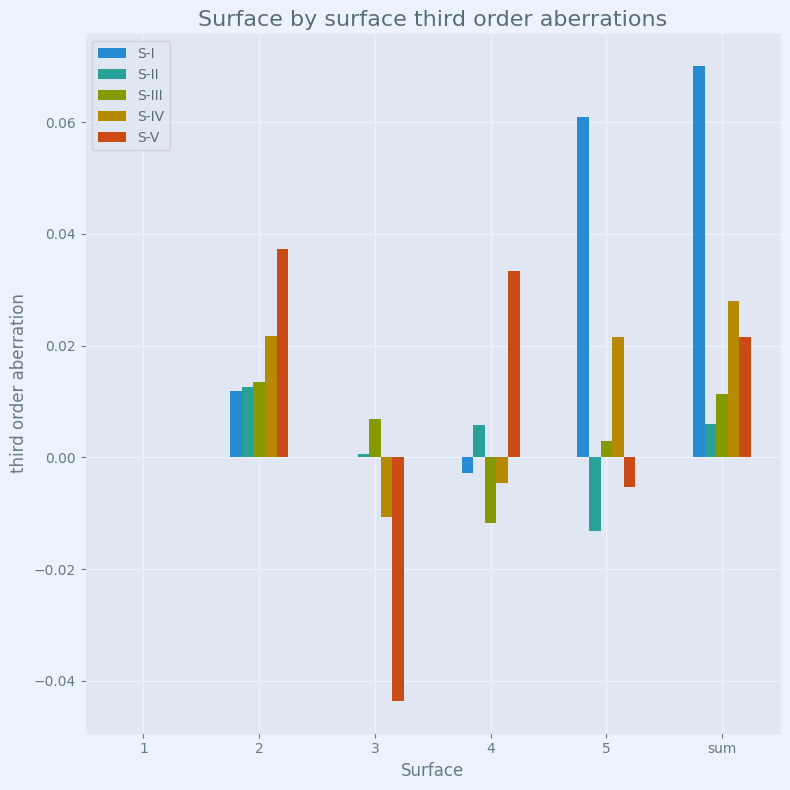

In [482]:
save_system(population_2[0])

mut rate 0.8

In [ ]:
evaluate_system(population[-1])

11.47198044559213

In [ ]:
[0.26830148729889425,
 4.397006845745857,
 -0.050038147338059814,
 7.129113617535491,
 -0.015367030821811081,
 -19.585445271638893,
 -0.3053000385203879]